# North Atlantic Budget

Let's analyze the SWMT and mass transport within different defined boxes in the North Atlantic, to try to pinpoint advection of nordic waters



In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
from dask.distributed import Client
from scipy.interpolate import interp1d

import xarray as xr
import cf_xarray as cfxr

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34605,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:43125,Total threads: 4
Dashboard: /proxy/43405/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:36177,


## Part 1 - Defining regions

In [3]:
session = cc.database.create_session('/home/156/wf4500/databases/access/temporary_DSW.db')

In [4]:
start_time='1909-01'
end_time='1909-12'
time_slice=slice(start_time,end_time)

In [5]:
experiment = '01deg_jra55v13_ryf9091_21mbath'
ht_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"ht", session, \
                               n=1).load()

In [6]:
mld_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"mld", session, \
                               frequency='1 monthly',start_time="1909-01-01",\
                               end_time="1909-12-31",\
                              chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).sel(time=time_slice).load()

mld_1mtop =mld_1mtop.isel(time=[0,1,2,3,11]).mean('time')

Defining the regions based on MLD, so we can set uop the Labrador sea as one thing only

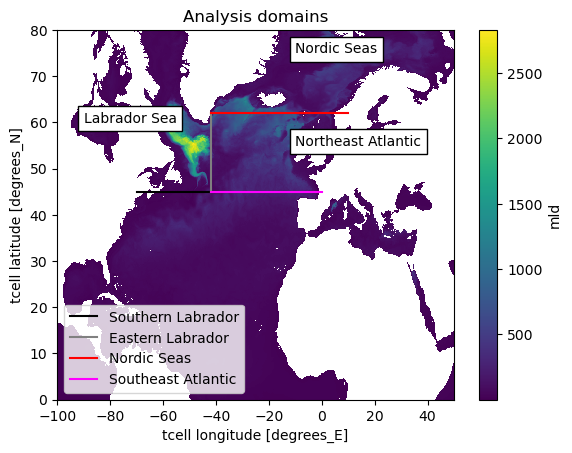

In [7]:
mld_1mtop.plot()
plt.plot([-70,-42],[45,45],'black',label='Southern Labrador')
plt.plot([-42,-42],[45,62],'grey',label='Eastern Labrador')
plt.plot([-42,10],[62,62],'red',label='Nordic Seas')
plt.plot([-42,0],[45,45],'magenta',label='Southeast Atlantic')

plt.text(-90,60,'Labrador Sea',color='black', bbox=dict(facecolor='white', edgecolor='black'))
plt.text(-10,55,'Northeast Atlantic',color='black', bbox=dict(facecolor='white', edgecolor='black'))
plt.text(-10,75,'Nordic Seas',color='black', bbox=dict(facecolor='white', edgecolor='black'))
plt.title('Analysis domains')

plt.xlim(-100,50); plt.ylim(0,80)
plt.legend()

## Part 2 - SWMT import and slicing

In [8]:
import glob

In [9]:
%%time
#################### Control case################
#control case SWMT
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/01deg_jra55v13_ryf9091_21mbath/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
c21mbath=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))

#heat
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/01deg_jra55v13_ryf9091_21mbath/yr*/HT_*.nc"))
print("%i netcdf data files"%len(gl))
Hc21mbath=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))

#Salt
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/01deg_jra55v13_ryf9091_21mbath/yr*/ST_*.nc"))
print("%i netcdf data files"%len(gl))
Sc21mbath=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))


#################### 5mtop################
#5mtop SWMT
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/ryf_5mtoponly/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
r5mtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))



#5mtop heat transformation
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/ryf_5mtoponly/yr*/HT_*.nc"))
print("%i netcdf data files"%len(gl))
Hr5mtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))

#5mtop Salt transformation
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/ryf_5mtoponly/yr*/ST_*.nc"))
print("%i netcdf data files"%len(gl))
Sr5mtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))



#################### halfmtop################
#5mtop SWMT
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/ryf_halfmtop/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
halfmtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))



#5mtop heat transformation
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/ryf_halfmtop/yr*/HT_*.nc"))
print("%i netcdf data files"%len(gl))
Hhalfmtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))

#5mtop Salt transformation
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/NA_sigma0_SWMT/ryf_halfmtop/yr*/ST_*.nc"))
print("%i netcdf data files"%len(gl))
Shalfmtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested').sel(xt_ocean=slice(-100,70))



10 netcdf data files
0.3.0
10 netcdf data files
10 netcdf data files
10 netcdf data files
10 netcdf data files
10 netcdf data files
10 netcdf data files
10 netcdf data files
10 netcdf data files
CPU times: user 4.42 s, sys: 1.73 s, total: 6.15 s
Wall time: 11.2 s


In [10]:
c21mbath = c21mbath.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
r5mtop = r5mtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
halfmtop = halfmtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
Hc21mbath = Hc21mbath.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
Hr5mtop = Hr5mtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
Hhalfmtop = Hhalfmtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
Sc21mbath = Sc21mbath.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
Sr5mtop = Sr5mtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})
Shalfmtop = Shalfmtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})


In [11]:
#Importing area to convert SWMT into sverdrups
areat_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"area_t", session, \
                               n=1).sel(xt_ocean=slice(-100,70)).sel(yt_ocean=slice(45,90))
areat_1mtop.chunk(chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).load()

<xarray.DataArray 'area_t' (yt_ocean: 950, xt_ocean: 1700)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -99.95 -99.85 -99.75 ... 69.75 69.85 69.95
  * yt_ocean  (yt_ocean) float64 45.04 45.11 45.18 45.25 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...

#### Nordic seas transformation

In [12]:
nordic_latslice=slice(62,90)
nordic_lonslice=slice(-42,50)

In [13]:
# Transformation in North Atlantic total on the control #########################
#Control total
nordic_c21mbath_total = (c21mbath.surface_water_mass_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_c21mbath_total = nordic_c21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
nordic_Hc21mbath_total = (Hc21mbath.binned_heat_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_Hc21mbath_total = nordic_Hc21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
nordic_Sc21mbath_total = (Sc21mbath.binned_salt_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_Sc21mbath_total = nordic_Sc21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()


# 5MTOP #########################
#Control total
nordic_r5mtop_total = (r5mtop.surface_water_mass_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_r5mtop_total = nordic_r5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
nordic_Hr5mtop_total = (Hr5mtop.binned_heat_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_Hr5mtop_total = nordic_Hr5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
nordic_Sr5mtop_total = (Sr5mtop.binned_salt_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_Sr5mtop_total = nordic_Sr5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()


# halfMTOP #########################
#Control total
nordic_halfmtop_total = (halfmtop.surface_water_mass_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_halfmtop_total = nordic_halfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
nordic_Hhalfmtop_total = (Hhalfmtop.binned_heat_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_Hhalfmtop_total = nordic_Hhalfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
nordic_Shalfmtop_total = (Shalfmtop.binned_salt_transformation.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) * areat_1mtop.sel(yt_ocean=nordic_latslice,xt_ocean=nordic_lonslice) )/1e6
nordic_Shalfmtop_total = nordic_Shalfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()


#### Labrador Seas transformation

In [14]:
lab_latslice=slice(45,90)
lab_lonslice=slice(-100,-42)

In [15]:
# Transformation in North Atlantic total on the control #########################
#Control total
lab_c21mbath_total = (c21mbath.surface_water_mass_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_c21mbath_total = lab_c21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
lab_Hc21mbath_total = (Hc21mbath.binned_heat_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_Hc21mbath_total = lab_Hc21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
lab_Sc21mbath_total = (Sc21mbath.binned_salt_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_Sc21mbath_total = lab_Sc21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()


# 5MTOP #########################
#Control total
lab_r5mtop_total = (r5mtop.surface_water_mass_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_r5mtop_total = lab_r5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
lab_Hr5mtop_total = (Hr5mtop.binned_heat_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_Hr5mtop_total = lab_Hr5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
lab_Sr5mtop_total = (Sr5mtop.binned_salt_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_Sr5mtop_total = lab_Sr5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()


# halfMTOP #########################
#Control total
lab_halfmtop_total = (halfmtop.surface_water_mass_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_halfmtop_total = lab_halfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
lab_Hhalfmtop_total = (Hhalfmtop.binned_heat_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_Hhalfmtop_total = lab_Hhalfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
lab_Shalfmtop_total = (Shalfmtop.binned_salt_transformation.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) * areat_1mtop.sel(yt_ocean=lab_latslice,xt_ocean=lab_lonslice) )/1e6
lab_Shalfmtop_total = lab_Shalfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()


#### Northeast Atlantic transformation

In [16]:
ne_latslice=slice(45,62)
ne_lonslice=slice(-42,50)

In [17]:
# Transformation in North Atlantic total on the control #########################
#Control total
NE_c21mbath_total = (c21mbath.surface_water_mass_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_c21mbath_total = NE_c21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
NE_Hc21mbath_total = (Hc21mbath.binned_heat_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_Hc21mbath_total = NE_Hc21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
NE_Sc21mbath_total = (Sc21mbath.binned_salt_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_Sc21mbath_total = NE_Sc21mbath_total.sum(['xt_ocean', 'yt_ocean']).load()


# 5MTOP #########################
#Control total
NE_r5mtop_total = (r5mtop.surface_water_mass_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_r5mtop_total = NE_r5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
NE_Hr5mtop_total = (Hr5mtop.binned_heat_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_Hr5mtop_total = NE_Hr5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
NE_Sr5mtop_total = (Sr5mtop.binned_salt_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_Sr5mtop_total = NE_Sr5mtop_total.sum(['xt_ocean', 'yt_ocean']).load()


# halfMTOP #########################
#Control total
NE_halfmtop_total = (halfmtop.surface_water_mass_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_halfmtop_total = NE_halfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control heat
NE_Hhalfmtop_total = (Hhalfmtop.binned_heat_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_Hhalfmtop_total = NE_Hhalfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()
#Control salt
NE_Shalfmtop_total = (Shalfmtop.binned_salt_transformation.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) * areat_1mtop.sel(yt_ocean=ne_latslice,xt_ocean=ne_lonslice) )/1e6
NE_Shalfmtop_total = NE_Shalfmtop_total.sum(['xt_ocean', 'yt_ocean']).load()


## Part 3 - Mass transports import and slicing

##### Nordic Seas

New start and ending times are

In [18]:
start_time='1900-01'
end_time='1909-12'
time_slice=slice(start_time,end_time)
nordic_lon_slice=slice(-42,10)
nordic_lat_ind=62
rho_0=1025

In [19]:
# Nordic MERIDIONAL Transports####

#control - 1mtop
NordicTY_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=nordic_lon_slice).sel(grid_yu_ocean=nordic_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#5mtop
NordicTY_5mtop = cc.querying.getvar('ryf_5mtoponly',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=nordic_lon_slice).sel(grid_yu_ocean=nordic_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#halfmtop
NordicTY_halfmtop = cc.querying.getvar('ryf_halfmtop',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=nordic_lon_slice).sel(grid_yu_ocean=nordic_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')

# Divided by density ref to get m3/s
NordicTY_1mtop = NordicTY_1mtop/(1e6*rho_0)
NordicTY_5mtop = NordicTY_5mtop/(1e6*rho_0)
NordicTY_halfmtop = NordicTY_halfmtop/(1e6*rho_0)


NordicTY_1mtop.load()
NordicTY_5mtop.load()
NordicTY_halfmtop.load()

<xarray.DataArray 'ty_trans_rho' (year: 10, potrho: 80, grid_xt_ocean: 520)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_xt_ocean  (grid_xt_ocean) float64 -41.95 -41.85 -41.75 ... 9.85 9.95
    grid_yu_ocean  float64 62.01
  * year           (year) int64 1900 1901 1902 1903 1904 ... 1906 1907 1908 1909

##### Southern Labrador Sea

In [20]:
labrador_lon_slice=slice(-70,-42)
labrador_lat_ind=45

In [21]:
# Labrador MERIDIONAL Transports####

#control - 1mtop
LabTY_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=labrador_lon_slice).sel(grid_yu_ocean=labrador_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#5mtop
LabTY_5mtop = cc.querying.getvar('ryf_5mtoponly',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=labrador_lon_slice).sel(grid_yu_ocean=labrador_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#halfmtop
LabTY_halfmtop = cc.querying.getvar('ryf_halfmtop',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=labrador_lon_slice).sel(grid_yu_ocean=labrador_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')

# Divided by density ref to get m3/s
LabTY_1mtop = LabTY_1mtop/(1e6*rho_0)
LabTY_5mtop = LabTY_5mtop/(1e6*rho_0)
LabTY_halfmtop = LabTY_halfmtop/(1e6*rho_0)


LabTY_1mtop.load()
LabTY_5mtop.load()
LabTY_halfmtop.load()

<xarray.DataArray 'ty_trans_rho' (year: 10, potrho: 80, grid_xt_ocean: 280)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_xt_ocean  (grid_xt_ocean) float64 -69.95 -69.85 ... -42.15 -42.05
    grid_yu_ocean  float64 45.0
  * year           (year) int64 1900 1901 1902 1903 1904 ... 1906 1907 1908 1909

##### Southeast Atlantic

In [22]:
SE_lon_slice=slice(-42,0)
SE_lat_ind=45

In [23]:
# Southeast Atlantic MERIDIONAL Transports####

#control - 1mtop
SeTY_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=SE_lon_slice).sel(grid_yu_ocean=SE_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#5mtop
SeTY_5mtop = cc.querying.getvar('ryf_5mtoponly',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=SE_lon_slice).sel(grid_yu_ocean=SE_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#halfmtop
SeTY_halfmtop = cc.querying.getvar('ryf_halfmtop',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=SE_lon_slice).sel(grid_yu_ocean=SE_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')

# Divided by density ref to get m3/s
SeTY_1mtop = SeTY_1mtop/(1e6*rho_0)
SeTY_5mtop = SeTY_5mtop/(1e6*rho_0)
SeTY_halfmtop = SeTY_halfmtop/(1e6*rho_0)


SeTY_1mtop.load()
SeTY_5mtop.load()
SeTY_halfmtop.load()

<xarray.DataArray 'ty_trans_rho' (year: 10, potrho: 80, grid_xt_ocean: 420)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_xt_ocean  (grid_xt_ocean) float64 -41.95 -41.85 -41.75 ... -0.15 -0.05
    grid_yu_ocean  float64 45.0
  * year           (year) int64 1900 1901 1902 1903 1904 ... 1906 1907 1908 1909

##### Eastern Labrador

Here we want the zonal transports

In [24]:
EL_lon_ind=-42
EL_lat_slice=slice(45,62)

In [25]:
# Eastern Labrador ZONAL Transports####
#control - 1mtop
ElTY_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"tx_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xu_ocean':'100gb','grid_yt_ocean':'100gb'}).sel(grid_xu_ocean=EL_lon_ind,method='nearest').sel(grid_yt_ocean=EL_lat_slice)\
.sel(time=time_slice).groupby('time.year').mean('time')


#5mtop
ElTY_5mtop = cc.querying.getvar('ryf_5mtoponly',"tx_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xu_ocean':'100gb','grid_yt_ocean':'100gb'}).sel(grid_xu_ocean=EL_lon_ind,method='nearest').sel(grid_yt_ocean=EL_lat_slice)\
.sel(time=time_slice).groupby('time.year').mean('time')


#halfmtop
ElTY_halfmtop = cc.querying.getvar('ryf_halfmtop',"tx_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xu_ocean':'100gb','grid_yt_ocean':'100gb'}).sel(grid_xu_ocean=EL_lon_ind,method='nearest').sel(grid_yt_ocean=EL_lat_slice)\
.sel(time=time_slice).groupby('time.year').mean('time')

# Divided by density ref to get m3/s
ElTY_1mtop = ElTY_1mtop/(1e6*rho_0)
ElTY_5mtop = ElTY_5mtop/(1e6*rho_0)
ElTY_halfmtop = ElTY_halfmtop/(1e6*rho_0)


ElTY_1mtop.load()
ElTY_5mtop.load()
ElTY_halfmtop.load()

<xarray.DataArray 'tx_trans_rho' (year: 10, potrho: 80, grid_yt_ocean: 291)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
    grid_xu_ocean  float64 -42.0
  * grid_yt_ocean  (grid_yt_ocean) float64 45.04 45.11 45.18 ... 61.94 61.98
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * year           (year) int64 1900 1901 1902 1903 1904 ... 1906 1907 1908 1909

## Part 4 - Surface and vertical analysis per region

In [26]:
#defining multiline plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

#### Nordic seas

In [27]:
tiled_bins=np.tile(nordic_c21mbath_total.isopycnal_bins,[10,1])
tiled_bins_rev=np.tile(nordic_c21mbath_total.isopycnal_bins.\
sel(isopycnal_bins=slice(None,None,-1)),[10,1])

tiled_bins_sigma2=np.tile(NordicTY_1mtop.potrho,[10,1])

In [28]:
#SWMT, from bottom to top
nordic_cell_thickening= (nordic_r5mtop_total-nordic_c21mbath_total).rolling(isopycnal_bins=15, center=True).mean()
nordic_5mtop_anom= (nordic_r5mtop_total-nordic_r5mtop_total.isel(time=0))

# cumulative transport
NordicTY_1mtop_cumsum = ((NordicTY_1mtop.isel(year=-1).sum('grid_xt_ocean')).sel(potrho=slice(None,None,-1))).cumsum(dim='potrho')
NordicTY_5mtop_cumsum = ((NordicTY_5mtop.isel(year=-1).sum('grid_xt_ocean')).sel(potrho=slice(None,None,-1))).cumsum(dim='potrho')
nordicTY_cell_thickening=  ((NordicTY_5mtop - NordicTY_1mtop).sum('grid_xt_ocean')/1e6)



In [29]:
figpath='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports/figs/'

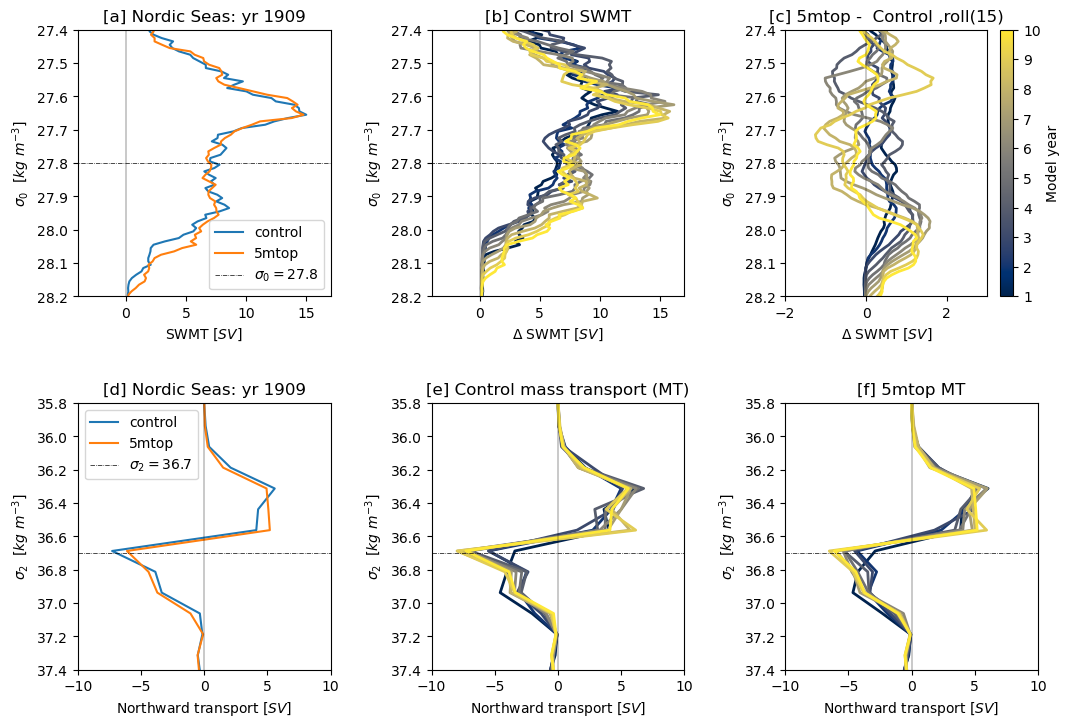

In [30]:
figure = plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(2,3,1)
plt.plot(nordic_c21mbath_total.isel(time=-1),nordic_c21mbath_total.isopycnal_bins,\
         color='tab:blue',label='control')
plt.plot(nordic_r5mtop_total.isel(time=-1),nordic_r5mtop_total.isopycnal_bins,\
         color='tab:orange',label='5mtop')
# plt.plot(nordic_halfmtop_total.isel(time=-1),nordic_halfmtop_total.isopycnal_bins,\
#          color='tab:green',label='halfmtop')

plt.title('[a] Nordic Seas: yr 1909')
plt.plot([-5,30],[27.8,27.8],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.8$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(28.2,27.4)
plt.xlim(-4,17); 
plt.legend()
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"SWMT $[SV]$")


plt.subplot(2,3,2)
yint = np.arange(1, 11, 1)
lc=multiline(nordic_c21mbath_total,tiled_bins, yint, cmap='cividis', lw=2)

plt.title('[b] Control SWMT')
plt.plot([-6,30],[27.8,27.8],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.8$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(28.2,27.4)
plt.xlim(-4,17); 
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"$\Delta$ SWMT $[SV]$")


ax = plt.subplot(2,3,3)
yint = np.arange(1, 11, 1)
lc=multiline(nordic_cell_thickening,tiled_bins, yint, cmap='cividis', lw=2)

plt.title('[c] 5mtop -  Control ,roll(15)')
plt.plot([-6,30],[27.8,27.8],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.8$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(28.2,27.4)
plt.xlim(-2,3);
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"$\Delta$ SWMT $[SV]$")
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))




plt.subplot(2,3,4)
plt.plot(NordicTY_1mtop.isel(year=-1).cf.sum('longitude'),NordicTY_1mtop.potrho-1000,\
         color='tab:blue',label='control')
plt.plot(NordicTY_5mtop.isel(year=-1).cf.sum('longitude'),NordicTY_5mtop.potrho-1000,\
         color='tab:orange',label='5mtop')
# plt.plot(NordicTY_halfmtop.isel(year=-1).sum('grid_xt_ocean')/1e6,NordicTY_halfmtop.potrho-1000,\
#          color='tab:green',label='halfmtop')

plt.title('[d] Nordic Seas: yr 1909')
plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-10,10); 
plt.legend()
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.subplot(2,3,5)
yint = np.arange(1, 11, 1)
lc=multiline(NordicTY_1mtop.cf.sum('longitude'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[e] Control mass transport (MT)')
plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-10,10);
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")



plt.subplot(2,3,6)
yint = np.arange(1, 11, 1)
#lc=multiline(nordicTY_cell_thickening,tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)
lc=multiline(NordicTY_5mtop.cf.sum('longitude'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[f] 5mtop MT')
plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
# plt.xlim(-2,3);
plt.xlim(-10,10);
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.savefig(figpath + 'Nordic_SWMT_MST_budget.png',bbox_inches='tight',dpi=300)

What does these plots tell us?

Top cell thickening causes an ~2 SV increase in SWMT crossing the densest classes ($\sigma_0>28$).

The Southward transport of densest water however decrease ( I guess it is unlikely that these super dense waters would be able to cross the iceland-scotland-greenland ridge)

**So it is likely that the increase in densities of SWMT in the Nordic seas aren't affecting the NADW overturning**

#### Northeast Atlantic

In [31]:
#SWMT, from bottom to top
NE_cell_thickening= (NE_r5mtop_total-NE_c21mbath_total).rolling(isopycnal_bins=15, center=True).mean()
NE_5mtop_anom= (NE_r5mtop_total-NE_r5mtop_total.isel(time=0))

# cumulative transport SOutheast meridional transport
SeTY_1mtop_cumsum = ((SeTY_1mtop.isel(year=-1).sum('grid_xt_ocean')).sel(potrho=slice(None,None,-1))/1e6).cumsum(dim='potrho')
SeTY_5mtop_cumsum = ((SeTY_5mtop.isel(year=-1).sum('grid_xt_ocean')).sel(potrho=slice(None,None,-1))/1e6).cumsum(dim='potrho')
SeTY_cell_thickening=  ((SeTY_5mtop - SeTY_1mtop).sum('grid_xt_ocean')/1e6)

# cumulative transport Eastern labrador zonal transport
ElTY_1mtop_cumsum = ((ElTY_1mtop.isel(year=-1).sum('grid_yt_ocean')).sel(potrho=slice(None,None,-1))/1e6).cumsum(dim='potrho')
ElTY_5mtop_cumsum = ((ElTY_5mtop.isel(year=-1).sum('grid_yt_ocean')).sel(potrho=slice(None,None,-1))/1e6).cumsum(dim='potrho')
ElTY_cell_thickening=  ((ElTY_5mtop - ElTY_1mtop).sum('grid_yt_ocean')/1e6)

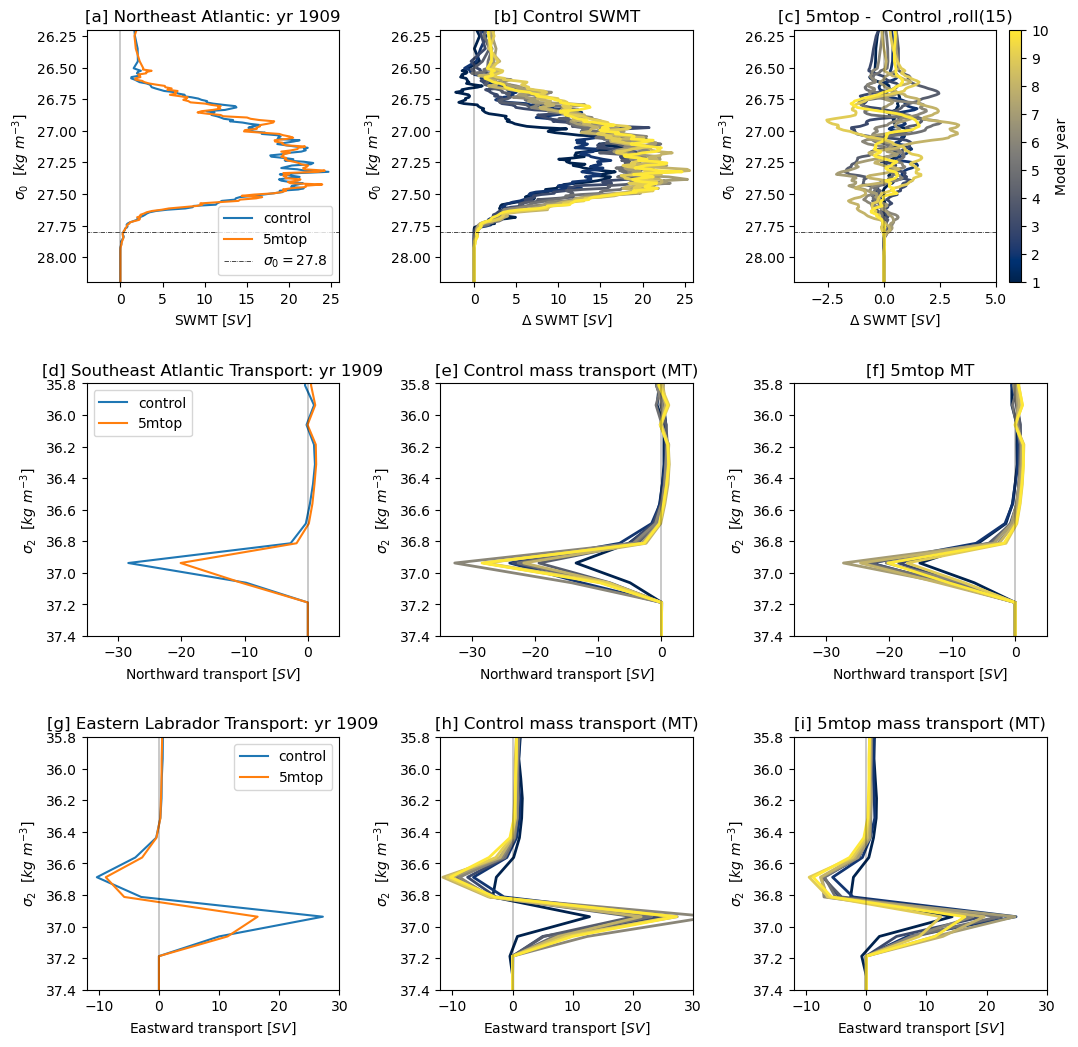

In [32]:
figure = plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(3,3,1)
plt.plot(NE_c21mbath_total.isel(time=-1),NE_c21mbath_total.isopycnal_bins,\
         color='tab:blue',label='control')
plt.plot(NE_r5mtop_total.isel(time=-1),NE_r5mtop_total.isopycnal_bins,\
         color='tab:orange',label='5mtop')
# plt.plot(nordic_halfmtop_total.isel(time=-1),nordic_halfmtop_total.isopycnal_bins,\
#          color='tab:green',label='halfmtop')

plt.title('[a] Northeast Atlantic: yr 1909')
plt.plot([-5,30],[27.8,27.8],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.8$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(28.2,26.2)
plt.xlim(-4,26); 
plt.legend()
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"SWMT $[SV]$")


plt.subplot(3,3,2)
yint = np.arange(1, 11, 1)
lc=multiline(NE_c21mbath_total,tiled_bins, yint, cmap='cividis', lw=2)

plt.title('[b] Control SWMT')
plt.plot([-6,30],[27.8,27.8],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.8$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(28.2,26.2)
plt.xlim(-4,26); 
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"$\Delta$ SWMT $[SV]$")


ax = plt.subplot(3,3,3)
yint = np.arange(1, 11, 1)
lc=multiline(NE_cell_thickening,tiled_bins, yint, cmap='cividis', lw=2)

plt.title('[c] 5mtop -  Control ,roll(15)')
plt.plot([-6,30],[27.8,27.8],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.8$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(28.2,26.2)
plt.xlim(-4,5); 
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"$\Delta$ SWMT $[SV]$")
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))




plt.subplot(3,3,4)
plt.plot(SeTY_1mtop.isel(year=-1).sum('grid_xt_ocean'),SeTY_1mtop.potrho-1000,\
         color='tab:blue',label='control')
plt.plot(SeTY_5mtop.isel(year=-1).sum('grid_xt_ocean'),SeTY_5mtop.potrho-1000,\
         color='tab:orange',label='5mtop')
# plt.plot(NordicTY_halfmtop.isel(year=-1).sum('grid_xt_ocean')/1e6,NordicTY_halfmtop.potrho-1000,\
#          color='tab:green',label='halfmtop')

plt.title('[d] Southeast Atlantic Transport: yr 1909')
#plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-35,5); 
plt.legend()
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.subplot(3,3,5)
yint = np.arange(1, 11, 1)
lc=multiline(SeTY_1mtop.sum('grid_xt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[e] Control mass transport (MT)')
# plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-35,5); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")



plt.subplot(3,3,6)
yint = np.arange(1, 11, 1)
#lc=multiline(nordicTY_cell_thickening,tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)
lc=multiline(SeTY_5mtop.sum('grid_xt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[f] 5mtop MT')
#plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-35,5); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.subplot(3,3,7)
plt.plot(ElTY_1mtop.isel(year=-1).sum('grid_yt_ocean'),ElTY_1mtop.potrho-1000,\
         color='tab:blue',label='control')
plt.plot(ElTY_5mtop.isel(year=-1).sum('grid_yt_ocean'),ElTY_5mtop.potrho-1000,\
         color='tab:orange',label='5mtop')


plt.title('[g] Eastern Labrador Transport: yr 1909')
# #plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-12,30); 
plt.legend()
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Eastward transport $[SV]$")

plt.subplot(3,3,8)
yint = np.arange(1, 11, 1)
lc=multiline(ElTY_1mtop.sum('grid_yt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[h] Control mass transport (MT)')
# # plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-12,30); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Eastward transport $[SV]$")


plt.subplot(3,3,9)
yint = np.arange(1, 11, 1)
lc=multiline(ElTY_5mtop.sum('grid_yt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[i] 5mtop mass transport (MT)')
# # plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-12,30); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Eastward transport $[SV]$")


plt.savefig(figpath + 'NortheastAtlantic_SWMT_MST_budget.png',bbox_inches='tight',dpi=300)

SWMT seem to show no change as we thicken the top cell. In any case, SWMT here seem to be too light to be NADW.

Also as we thicken the top cell, the southward transport of waters out of the basin derease in dense levels ( So this doesn't explain the increase in NADW.

We also have lower Eastward transport of denser waters ($\sigma_2>36.8$) from the Labrador towards this section (g),  Which likely explains the decrease soutwhard transport out of the basin (d)

**In summary, There is no change in SWMT in Northeast Atlantic, and a decrease in waters comiing from Labrador sea causes a decrease in dense water's export towards the South (likely NADW decrease since overturning shows NADW with $\sigma_2>36.6$**

#### Labrador Sea

In [33]:
#SWMT, from bottom to top
lab_cell_thickening= (lab_r5mtop_total-lab_c21mbath_total).rolling(isopycnal_bins=15, center=True).mean()
lab_5mtop_anom= (lab_r5mtop_total-lab_r5mtop_total.isel(time=0))

# cumulative transport South Labradort meridional transport
LabTY_1mtop_cumsum = ((LabTY_1mtop.isel(year=-1).sum('grid_xt_ocean')).sel(potrho=slice(None,None,-1))/1e6).cumsum(dim='potrho')
LabTY_5mtop_cumsum = ((LabTY_5mtop.isel(year=-1).sum('grid_xt_ocean')).sel(potrho=slice(None,None,-1))/1e6).cumsum(dim='potrho')
LabTY_cell_thickening=  ((LabTY_5mtop - LabTY_1mtop).sum('grid_xt_ocean')/1e6)


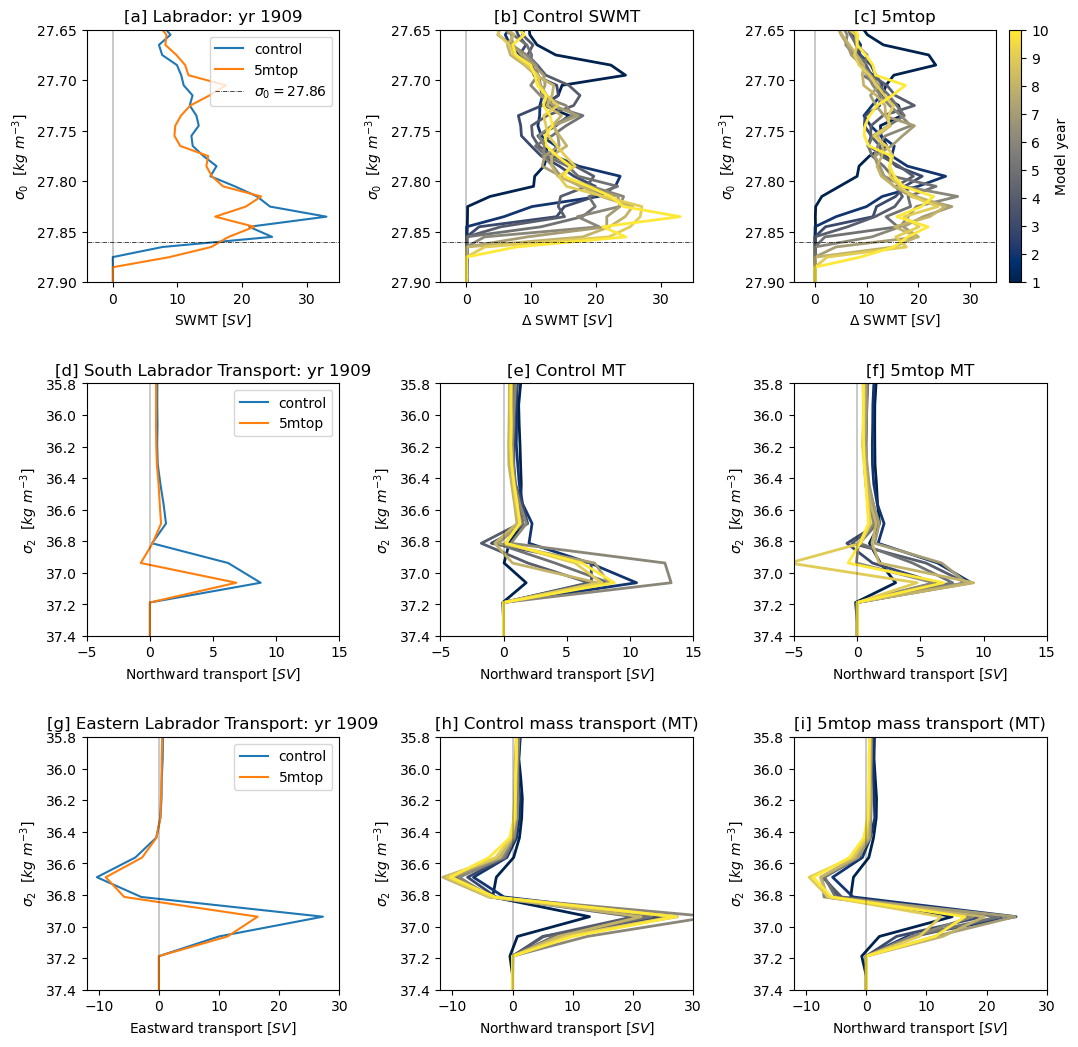

In [34]:
figure = plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(3,3,1)
plt.plot(lab_c21mbath_total.isel(time=-1),lab_c21mbath_total.isopycnal_bins,\
         color='tab:blue',label='control')
plt.plot(lab_r5mtop_total.isel(time=-1),lab_r5mtop_total.isopycnal_bins,\
         color='tab:orange',label='5mtop')
# plt.plot(nordic_halfmtop_total.isel(time=-1),nordic_halfmtop_total.isopycnal_bins,\
#          color='tab:green',label='halfmtop')

plt.title('[a] Labrador: yr 1909')
plt.plot([-5,40],[27.86,27.86],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.86$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(27.9,27.65)
plt.xlim(-4,35); 
plt.legend()
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"SWMT $[SV]$")


plt.subplot(3,3,2)
yint = np.arange(1, 11, 1)
lc=multiline(lab_c21mbath_total,tiled_bins, yint, cmap='cividis', lw=2)

plt.title('[b] Control SWMT')
plt.plot([-6,40],[27.86,27.86],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.86$") ; 
plt.plot([0,0],[24,30],lw=0.3,color='black') ; 
plt.ylim(27.9,27.65)
plt.xlim(-4,35); 
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"$\Delta$ SWMT $[SV]$")


ax = plt.subplot(3,3,3)
yint = np.arange(1, 11, 1)
lc=multiline(lab_r5mtop_total,tiled_bins, yint, cmap='cividis', lw=2)

plt.title('[c] 5mtop')
plt.plot([-6,40],[27.86,27.86],'-.',lw=0.5,color='black',label=r"$\sigma_0=27.86$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(27.9,27.65)
plt.xlim(-4,35); 
plt.ylabel(r"$\sigma_0\ \ [kg\ m^{-3}]$")
plt.xlabel(r"$\Delta$ SWMT $[SV]$")
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))




plt.subplot(3,3,4)
plt.plot(LabTY_1mtop.isel(year=-1).sum('grid_xt_ocean'),LabTY_1mtop.potrho-1000,\
         color='tab:blue',label='control')
plt.plot(LabTY_5mtop.isel(year=-1).sum('grid_xt_ocean'),LabTY_5mtop.potrho-1000,\
         color='tab:orange',label='5mtop')
# plt.plot(NordicTY_halfmtop.isel(year=-1).sum('grid_xt_ocean')/1e6,NordicTY_halfmtop.potrho-1000,\
#          color='tab:green',label='halfmtop')

plt.title('[d] South Labrador Transport: yr 1909')
#plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-5,15); 
plt.legend()
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.subplot(3,3,5)
lc=multiline(LabTY_1mtop.sum('grid_xt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)
# plt.plot(NordicTY_halfmtop.isel(year=-1).sum('grid_xt_ocean')/1e6,NordicTY_halfmtop.potrho-1000,\
#          color='tab:green',label='halfmtop')

plt.title('[e] Control MT')
#plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-5,15); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")



plt.subplot(3,3,6)
lc=multiline(LabTY_5mtop.sum('grid_xt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)
# plt.plot(NordicTY_halfmtop.isel(year=-1).sum('grid_xt_ocean')/1e6,NordicTY_halfmtop.potrho-1000,\
#          color='tab:green',label='halfmtop')

plt.title('[f] 5mtop MT')
#plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-5,15); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")



plt.subplot(3,3,7)
plt.plot(ElTY_1mtop.isel(year=-1).sum('grid_yt_ocean'),ElTY_1mtop.potrho-1000,\
         color='tab:blue',label='control')
plt.plot(ElTY_5mtop.isel(year=-1).sum('grid_yt_ocean'),ElTY_5mtop.potrho-1000,\
         color='tab:orange',label='5mtop')


plt.title('[g] Eastern Labrador Transport: yr 1909')
# #plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-12,30); 
plt.legend()
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Eastward transport $[SV]$")

plt.subplot(3,3,8)
yint = np.arange(1, 11, 1)
lc=multiline(ElTY_1mtop.sum('grid_yt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[h] Control mass transport (MT)')
# # plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-12,30); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.subplot(3,3,9)
yint = np.arange(1, 11, 1)
lc=multiline(ElTY_5mtop.sum('grid_yt_ocean'),tiled_bins_sigma2-1000, yint, cmap='cividis', lw=2)

plt.title('[i] 5mtop mass transport (MT)')
# # plt.plot([-10,30],[36.7,36.7],'-.',lw=0.5,color='black',label=r"$\sigma_2=36.7$") ; 
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(37.4,35.8)
plt.xlim(-12,30); 
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Northward transport $[SV]$")


plt.savefig(figpath + 'Labrador_SWMT_MST_budget.png',bbox_inches='tight',dpi=300)

OK, we see that in the Labrador, the SWMT decrease in $\sigma_0<27.86$, but increases in $\sigma_0>27.86$, but it is hard to see changes in transport. LEt's see the balance between in and out of the Labrador box

In [35]:

balance_1mtop = (LabTY_1mtop.isel(year=-1).sum('grid_xt_ocean')/1e6  - \
ElTY_1mtop.isel(year=-1).sum('grid_yt_ocean')/1e6).sel(potrho=slice(None,None,-1)).cumsum('potrho')

balance_5mtop = (LabTY_5mtop.isel(year=-1).sum('grid_xt_ocean')/1e6  - \
ElTY_5mtop.isel(year=-1).sum('grid_yt_ocean')/1e6).sel(potrho=slice(None,None,-1)).cumsum('potrho')

GEtting the transport in RAPID lats (26.5N) to see evolution

In [36]:
rapid_lon_slice=slice(-100,50)
rapid_lat_ind=26.5

In [38]:
# RAPID MERIDIONAL Transports####

#control - 1mtop
RAPID_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=rapid_lon_slice).sel(grid_yu_ocean=rapid_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#5mtop
RAPID_5mtop = cc.querying.getvar('ryf_5mtoponly',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=rapid_lon_slice).sel(grid_yu_ocean=rapid_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


#halfmtop
RAPID_halfmtop = cc.querying.getvar('ryf_halfmtop',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'}).sel(grid_xt_ocean=rapid_lon_slice).sel(grid_yu_ocean=rapid_lat_ind,method='nearest')\
.sel(time=time_slice).groupby('time.year').mean('time')


### DENSITIES





# Divided by density ref to get m3/s
RAPID_1mtop = RAPID_1mtop/(1e6*rho_0)
RAPID_5mtop = RAPID_5mtop/(1e6*rho_0)
RAPID_halfmtop = RAPID_halfmtop/(1e6*rho_0)


RAPID_1mtop.load()
RAPID_5mtop.load()
RAPID_halfmtop.load()

<xarray.DataArray 'ty_trans_rho' (year: 10, potrho: 80, grid_xt_ocean: 1500)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_xt_ocean  (grid_xt_ocean) float64 -99.95 -99.85 -99.75 ... 49.85 49.95
    grid_yu_ocean  float64 26.5
  * year           (year) int64 1900 1901 1902 1903 1904 ... 1906 1907 1908 1909

In [278]:
RAPID_1mtop_mean=RAPID_1mtop.isel(year=-1).cf.sum('longitude')
RAPID_5mtop_mean=RAPID_5mtop.isel(year=-1).cf.sum('longitude')
RAPID_halfmtop_mean=RAPID_halfmtop.isel(year=-1).cf.sum('longitude')

#calculating streamfunction in Rapid
RAPID_1mtop_meanSF = RAPID_1mtop_mean.cf.cumsum('vertical') - RAPID_1mtop_mean.cf.sum('vertical')
RAPID_5mtop_meanSF = RAPID_5mtop_mean.cf.cumsum('vertical') - RAPID_5mtop_mean.cf.sum('vertical')
RAPID_halfmtop_meanSF = RAPID_halfmtop_mean.cf.cumsum('vertical') - RAPID_halfmtop_mean.cf.sum('vertical')


#South 45 balance 
S45b_1mtop = LabTY_1mtop.isel(year=-1).cf.sum('longitude')  + SeTY_1mtop.isel(year=-1).cf.sum('longitude') 
S45b_5mtop = LabTY_5mtop.isel(year=-1).cf.sum('longitude')  + SeTY_5mtop.isel(year=-1).cf.sum('longitude') 
S45b_halfmtop = LabTY_halfmtop.isel(year=-1).cf.sum('longitude')  + SeTY_halfmtop.isel(year=-1).cf.sum('longitude')


#South 45 streamfunction
S45b_1mtopSF = S45b_1mtop.cf.cumsum('vertical') - S45b_1mtop.cf.sum('vertical')
S45b_5mtopSF = S45b_5mtop.cf.cumsum('vertical') - S45b_5mtop.cf.sum('vertical')
S45b_halfmtopSF = S45b_halfmtop.cf.cumsum('vertical') - S45b_halfmtop.cf.sum('vertical')

In [279]:
S45b_1mtop.sum(),S45b_5mtop.sum()

(<xarray.DataArray 'ty_trans_rho' ()>
 array(-1.4876976, dtype=float32)
 Coordinates:
     grid_yu_ocean  float64 45.0
     year           int64 1909,
 <xarray.DataArray 'ty_trans_rho' ()>
 array(-1.4738588, dtype=float32)
 Coordinates:
     grid_yu_ocean  float64 45.0
     year           int64 1909)

In [280]:

NADW_45N_1mtop = float(np.round(S45b_1mtop.sel(potrho=slice(1036.7,1038)).sum()*10)/10)

NADW_45N_5mtop = float(np.round(S45b_5mtop.sel(potrho=slice(1036.7,1038)).sum()*10)/10)

In [281]:
NADW_RAPID_1mtop = float(np.round(RAPID_1mtop_mean.sel(potrho=slice(1036.7,1038)).sum()*10)/10)
NADW_RAPID_5mtop = float(np.round(RAPID_5mtop_mean.sel(potrho=slice(1036.7,1038)).sum()*10)/10)

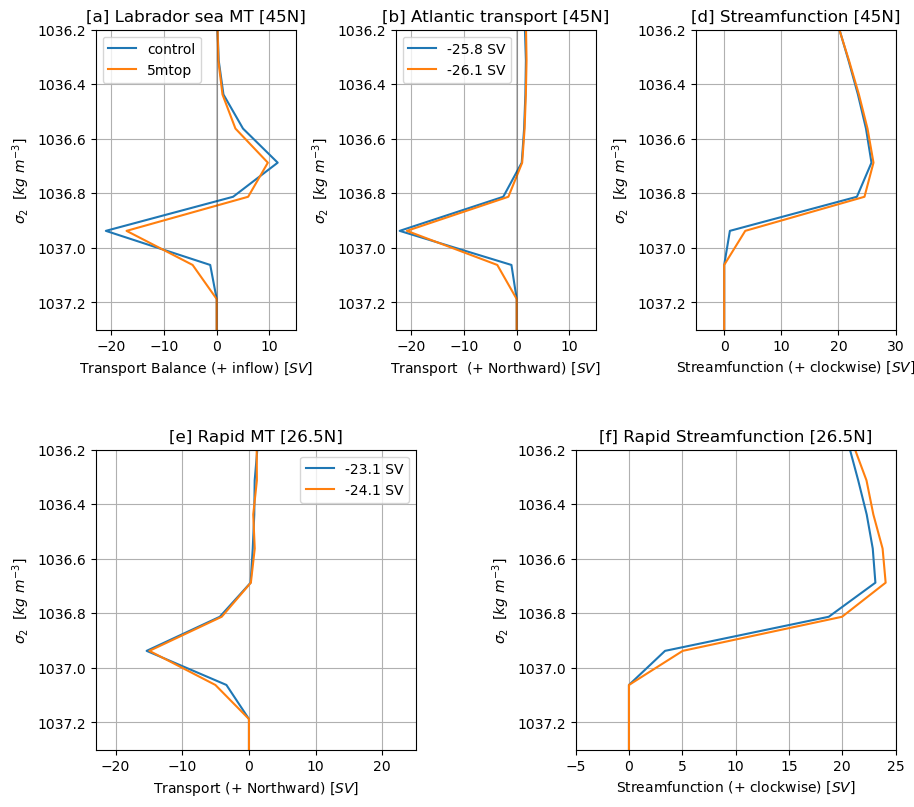

In [282]:
figure = plt.figure(figsize=(10,9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)

plt.subplot(2,3,1)
plt.plot(LabTY_1mtop.isel(year=-1).cf.sum('longitude')  - ElTY_1mtop.isel(year=-1).cf.sum('latitude'),\
LabTY_1mtop.potrho,\
         color='tab:blue',label='control')

plt.plot(LabTY_5mtop.isel(year=-1).cf.sum('longitude')  - ElTY_5mtop.isel(year=-1).cf.sum('latitude'),\
LabTY_1mtop.potrho,\
         color='tab:orange',label='5mtop')
plt.grid()
plt.plot([0,0],[24,2000],lw=0.3,color='black') ; 
plt.ylim(1037.3,1036.2)
plt.xlim(-23,15); 
plt.legend();
plt.title('[a] Labrador sea MT [45N]')
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Transport Balance (+ inflow) $[SV]$")


plt.subplot(2,3,2)
plt.plot(S45b_1mtop ,\
LabTY_1mtop.potrho,\
         color='tab:blue',label=str(NADW_45N_1mtop) + " SV")

plt.plot(S45b_5mtop ,\
LabTY_1mtop.potrho,\
         color='tab:orange',label=str(NADW_45N_5mtop) + " SV")
plt.grid()
plt.legend()
plt.plot([0,0],[24,2000],lw=0.3,color='black') ; 
plt.ylim(1037.3,1036.2)
plt.xlim(-23,15); 
plt.title('[b] Atlantic transport [45N]')
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Transport  (+ Northward) $[SV]$")

plt.subplot(2,3,3)

plt.plot(S45b_1mtopSF,\
RAPID_1mtop_mean.potrho,\
         color='tab:blue')
plt.plot(S45b_5mtopSF,\
RAPID_5mtop_mean.potrho,\
         color='tab:orange')

plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
#plt.ylim(1036,1028)
#plt.xlim(1.2,1.8)
plt.ylim(1037.3,1036.2)
plt.xlim(-5,30); 
plt.title('[d] Streamfunction [45N]')
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Streamfunction (+ clockwise) $[SV]$")
plt.grid()




plt.subplot(2,2,3)

plt.plot(RAPID_1mtop_mean,\
RAPID_1mtop_mean.potrho,\
         color='tab:blue',label=str(NADW_RAPID_1mtop) + " SV")
plt.plot(RAPID_5mtop_mean,\
RAPID_5mtop_mean.potrho,\
         color='tab:orange',label=str(NADW_RAPID_5mtop) + " SV")

plt.legend()
plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(1037.3,1036.2)
plt.xlim(-23,25); 
plt.title('[e] Rapid MT [26.5N]')
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Transport (+ Northward) $[SV]$")
plt.grid()



plt.subplot(2,2,4)

plt.plot(RAPID_1mtop_meanSF,\
RAPID_1mtop_mean.potrho,\
         color='tab:blue',label='control')
plt.plot(RAPID_5mtop_meanSF,\
RAPID_5mtop_mean.potrho,\
         color='tab:orange',label='5mtop')


plt.plot([0,0],[24,40],lw=0.3,color='black') ; 
plt.ylim(1037.3,1036.2)
plt.xlim(-5,25); 
plt.title('[f] Rapid Streamfunction [26.5N]')
plt.ylabel(r"$\sigma_2\ \ [kg\ m^{-3}]$")
plt.xlabel(r"Streamfunction (+ clockwise) $[SV]$")
plt.grid()





THe results coincides with a net increase in the outflow of denser waters, which likely increases NADW outflow. This likely explains the increase in NADW outflow in the model

SUMMARY


- OM2 forms NADW mostly in the Labrador Sea, which based on observations is not optimal ( as OSNAP suggest most of the NADW transport comes from East Greenland and overflow from nordic Seas.

- As we thicken the top cell, deep convection concentrates in a smaller region in the Labrador Sea

- SWMT suggests that this enhance SWMT towards the densest NADW water classes, and decrease SWMT in the lightest water classes

- increased SWMT in denser classes $\sigma_0>27.86$ increases NADW outflow (Mixing likely has an important role here)

**This suggests a very interesting result: increasing the top cell thickness, enhances convection of very dense waters in the Labrador Sea. This is interesting because overconvective Labrador sea is a well know problem when trying to reproduce the NADW formation in North Atlantic, therfore reducing the vertical resolution, decrease this overconvective behaviour, and helps correct the model bias in NADW formation. This agrees with MOC decreasing and getting closer to 17 SV when we make the top cell thinner**

Now the question is, why does the increase in top cell thickess decrease the dense SWMT on the Antarctic Shelf, and increases the dense SWMT on the North Atlantic?  

**[H1]** - A possible explanation is the KPP. According to [Van Roekel 2018], under free convection driven by surface cooling, KPP makes the OSBL (or MLD) too thick when increasing the top cell thickness ( which is likely a hint for overconvective system). In the Antarctic shelf the free convection is driven by salinity increase, and so the results of Van Roekel might not apply ( salinity diffusion is slower). The problem of this finding is that the increase in MLD is not widespread in the model when increasing the top cell thickness.

**[H2]** - As we decrease the top cell thickness, we decrease the impact of the OSBL mixing parameterization, and resolve better some of the surface fluxes. This helps correcting some of the biases in shelf AABW formation and NA NADW formation (Highly expeculative - needs literature search to test if this is the case)

## Surface water mass transformation and MLD maps

In [44]:
#importing it
time_slice=slice("1909-01-01","1909-12-31")
mld_1mtop = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"mld", session, \
                               frequency='1 monthly',start_time="1909-01-01",\
                               end_time="1909-12-31",\
                              chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).sel(time=time_slice).load()


mld_5mtop = cc.querying.getvar('ryf_5mtoponly',"mld", session, \
                               frequency='1 monthly',start_time="1909-01-01", \
                               end_time="1909-12-31",\
                              chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).sel(time=time_slice).load()

mld_halfmtop = cc.querying.getvar('ryf_halfmtop',"mld", session, \
                               frequency='1 monthly',start_time="1909-01-01", \
                                  end_time="1909-12-31",\
                                 chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).sel(time=time_slice).load()

Calculating mean mld for winter

In [45]:
MEANmld_1mtop=mld_1mtop.mean('time')
MEANmld_5mtop=mld_5mtop.mean('time')
MEANmld_halfmtop=mld_halfmtop.mean('time')

Calculating mean SWMT maps, for the densities we want

In [46]:
# Dense waters formation map
map_c21mbath = (c21mbath.sel(isopycnal_bins=slice(27.86,29)).mean('isopycnal_bins').\
isel(time=-1).surface_water_mass_transformation * areat_1mtop)/1e6
map_c21mbath.load()

map_r5mtop = (r5mtop.sel(isopycnal_bins=slice(27.86,29)).mean('isopycnal_bins').\
isel(time=-1).surface_water_mass_transformation * areat_1mtop)/1e6
map_r5mtop.load()


# Dense waters heat-driven formation map
map_Hc21mbath = (Hc21mbath.sel(isopycnal_bins=slice(27.86,29)).mean('isopycnal_bins').\
isel(time=-1).binned_heat_transformation * areat_1mtop)/1e6
map_Hc21mbath.load()

map_Hr5mtop = (Hr5mtop.sel(isopycnal_bins=slice(27.86,29)).mean('isopycnal_bins').\
isel(time=-1).binned_heat_transformation * areat_1mtop)/1e6
map_Hr5mtop.load()


# Dense waters SALT-driven formation map
map_Sc21mbath = (Sc21mbath.sel(isopycnal_bins=slice(27.86,29)).mean('isopycnal_bins').\
isel(time=-1).binned_salt_transformation * areat_1mtop)/1e6
map_Sc21mbath.load()

map_Sr5mtop = (Sr5mtop.sel(isopycnal_bins=slice(27.86,29)).mean('isopycnal_bins').\
isel(time=-1).binned_salt_transformation * areat_1mtop)/1e6
map_Sr5mtop.load()

<xarray.DataArray (yt_ocean: 950, xt_ocean: 1700)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 45.04 45.11 45.18 45.25 ... 89.89 89.94 89.98
  * xt_ocean  (xt_ocean) float64 -99.95 -99.85 -99.75 ... 69.75 69.85 69.95
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan

In [49]:
MEANmld_cellthickening = (MEANmld_5mtop - MEANmld_1mtop)
ht_1mtop0=ht_1mtop.fillna(0)

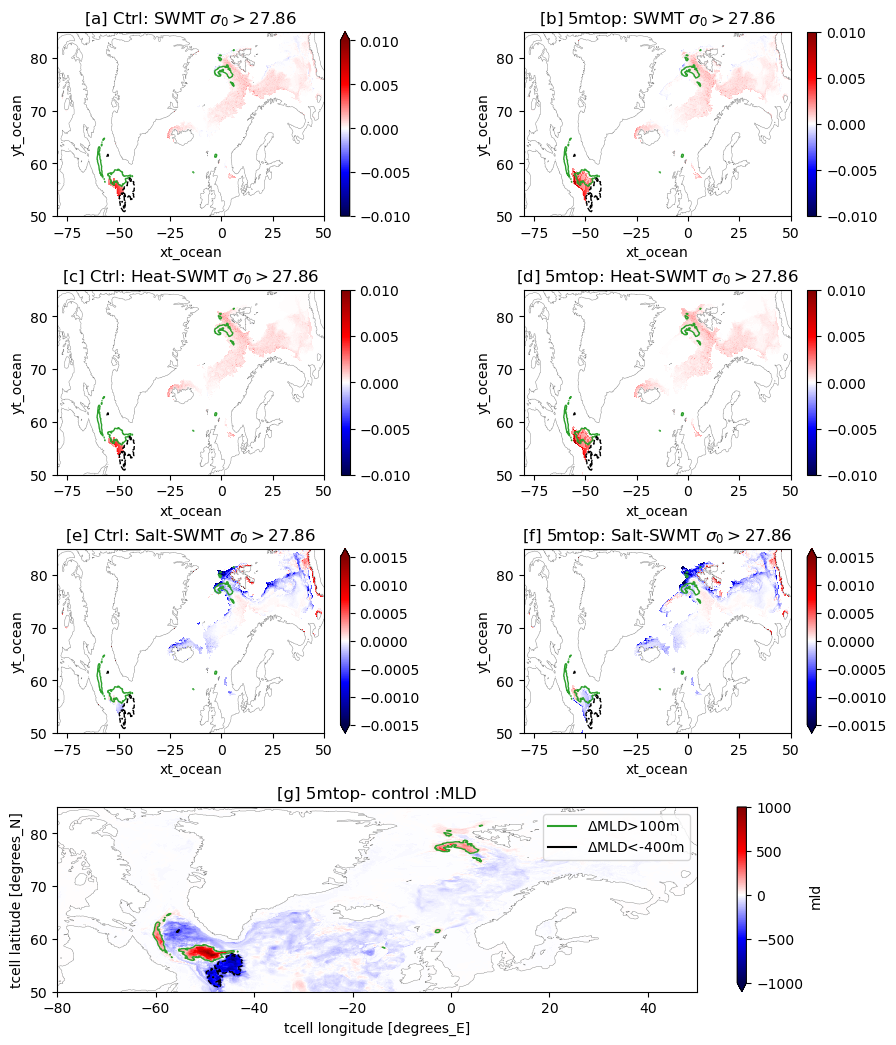

In [50]:
plt.figure(figsize=(10,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(4,2,1)
map_c21mbath.plot(vmin=-1e-2,vmax=1e-2,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.ylim(50,85); plt.xlim(-80,50);
plt.title(r"[a] Ctrl: SWMT $\sigma_0>27.86$")

plt.subplot(4,2,2)
map_r5mtop.plot(vmin=-1e-2,vmax=1e-2,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.ylim(50,85); plt.xlim(-80,50);
plt.title(r"[b] 5mtop: SWMT $\sigma_0>27.86$")

plt.subplot(4,2,3)
map_Hc21mbath.plot(vmin=-1e-2,vmax=1e-2,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.ylim(50,85); plt.xlim(-80,50);
plt.title(r"[c] Ctrl: Heat-SWMT $\sigma_0>27.86$")

plt.subplot(4,2,4)
map_Hr5mtop.plot(vmin=-1e-2,vmax=1e-2,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.ylim(50,85); plt.xlim(-80,50);
plt.title(r"[d] 5mtop: Heat-SWMT $\sigma_0>27.86$")


plt.subplot(4,2,5)
map_Sc21mbath.plot(vmin=-0.15e-2,vmax=0.15e-2,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.ylim(50,85); plt.xlim(-80,50);
plt.title(r"[e] Ctrl: Salt-SWMT $\sigma_0>27.86$")


plt.subplot(4,2,6)
map_Sr5mtop.plot(vmin=-0.15e-2,vmax=0.15e-2,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.ylim(50,85); plt.xlim(-80,50);
plt.title(r"[f] 5mtop: Salt-SWMT $\sigma_0>27.86$")

plt.subplot(4,1,4)
MEANmld_cellthickening.plot(vmin=-1000,vmax=1000,cmap='seismic')
plt.contour(ht_1mtop0.xt_ocean,ht_1mtop0.yt_ocean,ht_1mtop0,[0],colors='grey',linewidths=0.3)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[100],colors='tab:green',linewidths=1)
plt.contour(MEANmld_5mtop.xt_ocean,MEANmld_5mtop.yt_ocean,\
            MEANmld_cellthickening,[-400],colors='black',linewidths=1)
plt.plot([-60,-60],[0,10],color='tab:green',label=r"$\Delta$MLD>100m")
plt.plot([-60,-60],[0,10],color='black',label=r"$\Delta$MLD<-400m")
plt.ylim(50,85); plt.xlim(-80,50);
plt.legend()
plt.title(r"[g] 5mtop- control :MLD")

plt.savefig(figpath + 'NA_SWMT_plusMLD_surface.png',bbox_inches='tight',dpi=300)

Ok, this plot shows that a significant part of the increase in dense SWMT ($\sigma_0>27.86$) happens in the region of increased MLD with cell thickness. The increase in SWMT is also mostly driven by heat fluxes too. Meanwhile salt-driven light-SWMT also increases in that region, but the increase is 15% of the heat flux driven transformation

What we can see here is that it is not that the MLD necessairily increases everywhere where convection occurs. The top cell thickning actually increases MLD in the central Labrador, but it decreases a little more to the West (And I have no idea why). It is almost like it concentrates the convection to the north, where heat loss would be stronger, causing transformation to densest classes to increase.

**I guess the final question it is, why do we have this weird concentration of the Deep convection?**

## Total Atlantic Meridional Transports


I think the interpretations using streamfunction get a little misleading because of the reduction of the mean transport. I will calculate here then the total meridional transport in the Atlantic, and see the anomalies ( seem to be easier)

In [51]:
#GEtting Atlantic and Arctic Masks
Atlanticmask = xr.open_dataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/additional_files/imperfect_OM2_atlantic_mask.nc')
Atlantic_arctic = xr.open_dataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/additional_files/imperfect_OM2_atlanticandArctic_mask.nc')

Atlantic_arctic = Atlantic_arctic.__xarray_dataarray_variable__
Atlanticmask=Atlanticmask.atlantic


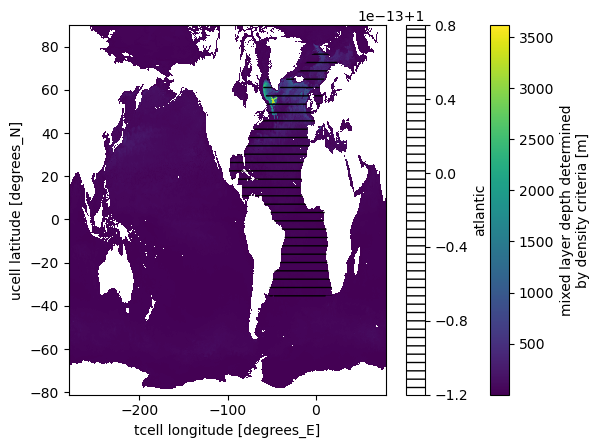

In [259]:
mld_1mtop.isel(time=0).plot()
Atlanticmask.plot.contourf(colors='none',hatches=[ ' -- '])

The hatched region is the only region being accounted for the transport

In [82]:
# # Atlantic Transports####

# #control - 1mtop
# Atlantic_1mtop = ((cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath',"ty_trans_rho",session,\
#                               frequency='1 monthly',start_time=start_time,end_time=end_time,\
#                               chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'})\
# .sel(time=time_slice).groupby('time.year').mean('time') * Atlanticmask)/(1e6 * rho_0))\
# .cf.sum('longitude').isel(year=-1)


#5mtop
Atlantic_5mtop = (cc.querying.getvar('ryf_5mtoponly',"ty_trans_rho",session,\
                              frequency='1 monthly',start_time=start_time,end_time=end_time,\
                              chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'})\
.sel(time=time_slice).mean('time') )

Atlantic_5mtop = ((Atlantic_5mtop* Atlanticmask)/(1e6 * rho_0)).cf.sum('longitude')



# #halfmtop
# Atlantic_halfmtop = ((cc.querying.getvar('ryf_halfmtop',"ty_trans_rho",session,\
#                               frequency='1 monthly',start_time=start_time,end_time=end_time,\
#                               chunks={'grid_xt_ocean':'100gb','grid_yu_ocean':'100gb'})\
# .sel(time=time_slice).groupby('time.year').mean('time')  *Atlanticmask)/(1e6 * rho_0))\
# .cf.sum('longitude').isel(year=-1)



In [85]:
# Atlantic_1mtop.load()

In [86]:
#Atlantic_5mtop.load()

Total NADW transports , Upper and Lower for boxplot (in different lats)


In [286]:
#density slices of NADW
NADW_slice=slice(1036.7,1037.2)
UNADW_slice=slice(1036.7,1036.98)
LNADW_slice=slice(1036.98,1037.2)

#1MTOP
NADW45_1mtop = Atlantic_1mtop.where(Atlantic_1mtop<0).sel(grid_yu_ocean=45,method='nearest').sel(potrho=NADW_slice).sum()
NADW26_1mtop = Atlantic_1mtop.where(Atlantic_1mtop<0).sel(grid_yu_ocean=26.5,method='nearest').sel(potrho=NADW_slice).sum()
UNADW45_1mtop = Atlantic_1mtop.where(Atlantic_1mtop<0).sel(grid_yu_ocean=45,method='nearest').sel(potrho=UNADW_slice).sum()
UNADW26_1mtop = Atlantic_1mtop.where(Atlantic_1mtop<0).sel(grid_yu_ocean=26.5,method='nearest').sel(potrho=UNADW_slice).sum()
LNADW45_1mtop = Atlantic_1mtop.where(Atlantic_1mtop<0).sel(grid_yu_ocean=45,method='nearest').sel(potrho=LNADW_slice).sum()
LNADW26_1mtop = Atlantic_1mtop.where(Atlantic_1mtop<0).sel(grid_yu_ocean=26.5,method='nearest').sel(potrho=LNADW_slice).sum()

#5mtop
NADW45_5mtop = Atlantic_5mtop.where(Atlantic_5mtop<0).sel(grid_yu_ocean=45,method='nearest').sel(potrho=NADW_slice).sum()
NADW26_5mtop = Atlantic_5mtop.where(Atlantic_5mtop<0).sel(grid_yu_ocean=26.5,method='nearest').sel(potrho=NADW_slice).sum()
UNADW45_5mtop = Atlantic_5mtop.where(Atlantic_5mtop<0).sel(grid_yu_ocean=45,method='nearest').sel(potrho=UNADW_slice).sum()
UNADW26_5mtop = Atlantic_5mtop.where(Atlantic_5mtop<0).sel(grid_yu_ocean=26.5,method='nearest').sel(potrho=UNADW_slice).sum()
LNADW45_5mtop = Atlantic_5mtop.where(Atlantic_5mtop<0).sel(grid_yu_ocean=45,method='nearest').sel(potrho=LNADW_slice).sum()
LNADW26_5mtop = Atlantic_5mtop.where(Atlantic_5mtop<0).sel(grid_yu_ocean=26.5,method='nearest').sel(potrho=LNADW_slice).sum()

#Arguments for the bocplot
x = ['1m ', '5m ', '1m', '5m']
y1 = [-UNADW45_1mtop , -UNADW45_5mtop, -UNADW26_1mtop, -UNADW26_5mtop ]  # UNADW [45,45,26,26]
y2 = [-LNADW45_1mtop , -LNADW45_5mtop, -LNADW26_1mtop, -LNADW26_5mtop ]  # LNADW [45,45,26,26]

x1m = [0,2]
y1m_1 = [-UNADW45_1mtop ,-UNADW26_1mtop, ]  # UNADW [45,26]
y1m_2 = [-LNADW45_1mtop ,  -LNADW26_1mtop ]  # LNADW [45,26]

x5m = [1,3]
y5m_1 = [-UNADW45_5mtop ,-UNADW26_5mtop, ]  # UNADW [45,26]
y5m_2 = [-LNADW45_5mtop ,  -LNADW26_5mtop ]  # LNADW [45,26]

In [287]:
#total NADW 45N
NADW45_1mtopstr = str(round(float(y1m_2[0]+y1m_1[0])*10)/10)
NADW45_5mtopstr = str(round(float(y5m_2[0]+y5m_1[0])*10)/10)

#total NADW 26N
NADW26_1mtopstr = str(round(float(y1m_2[1]+y1m_1[1])*10)/10)
NADW26_5mtopstr = str(round(float(y5m_2[1]+y5m_1[1])*10)/10)

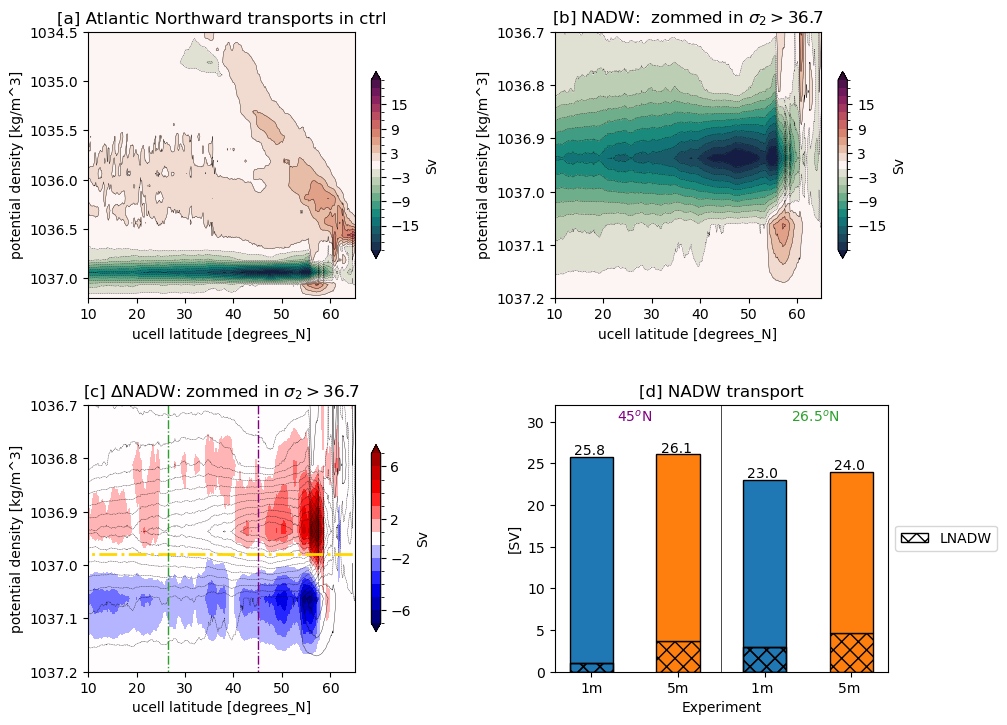

In [288]:
figure = plt.figure(figsize=(10,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

max_psi = 21 # Sv



plt.subplot(2,2,1)
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

Atlantic_1mtop.plot.contourf(levels=levels, 
                           cmap=cm.cm.curl, extend='both',
                           cbar_kwargs={'shrink': 0.7,'label': 'Sv', 'ticks': cbarticks})
Atlantic_1mtop.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.title('[a] Atlantic Northward transports in ctrl')
plt.ylim(1037.2,1034.5)
plt.xlim(10,65)


plt.subplot(2,2,2)
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

Atlantic_1mtop.plot.contourf(levels=levels, 
                           cmap=cm.cm.curl, extend='both',
                           cbar_kwargs={'shrink': 0.7,'label': 'Sv', 'ticks': cbarticks})
Atlantic_1mtop.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.title(r"[b] NADW:  zommed in $\sigma_2>36.7$")
plt.ylim(1037.2,1036.7)
plt.xlim(10,65)



plt.subplot(2,2,3)
max_psia = 7 # Sv
levelsa =  np.hstack((np.arange(-max_psia, 0, 1), np.flip(-np.arange(-max_psia, 0, 1))))
cbarticksa = np.hstack((np.flip(-np.arange(2, max_psia, 4)), np.arange(2, max_psia, 4)))

(Atlantic_5mtop - Atlantic_1mtop).plot.contourf(levels=levelsa, 
                           cmap='seismic', extend='both',
                           cbar_kwargs={'shrink': 0.7,'label': 'Sv', 'ticks': cbarticksa})
Atlantic_1mtop.plot.contour(levels=levels, colors='k', linewidths=0.25)
plt.plot([0,80],[1036.98,1036.98],'-.',color='gold',lw=2)
plt.plot([45,45],[1036.7,1037.2],'-.',color='purple',lw=1)
plt.plot([26.5,26.5],[1036.7,1037.2],'-.',color='tab:green',lw=1)

plt.title(r"[c] $\Delta$NADW: zommed in $\sigma_2>36.7$")
plt.ylim(1037.2,1036.7)
plt.xlim(10,65)


ax = plt.subplot(2,2,4)
plt.bar(x1m,y1m_2,  color='tab:blue', hatch="xx", edgecolor='black',width=0.5)
plt.bar(x1m, y1m_1, color='tab:blue',bottom=y1m_2, edgecolor='black',width=0.5) #UNADW
plt.bar(x5m,y5m_2, color='tab:orange', hatch="xx", edgecolor='black',width=0.5)
plt.bar(x5m, y5m_1, color='tab:orange',  bottom=y5m_2, edgecolor='black',width=0.5) #UNADW
plt.bar(x1m,y1m_2,  color='none', hatch="xx", edgecolor='black',width=0.5,label='LNADW')
ax.set_xticklabels(['','1m','5m','1m ','5m '])
plt.ylim(0,32)
plt.text(-0.2,26,NADW45_1mtopstr)
plt.text(0.8,26.3,NADW45_5mtopstr)
plt.text(1.8,23.3,NADW26_1mtopstr)
plt.text(2.8,24.3,NADW26_5mtopstr)
plt.plot([1.5,1.5],[0,32],color='black',lw=0.5)
plt.text(0.3,30,r"45$^o$N",color='purple')
plt.text(2.3,30,r"26.5$^o$N",color='tab:green')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('[SV]')
plt.xlabel('Experiment')
plt.title("[d] NADW transport")


plt.savefig(figpath + 'Overturning_changes.png',bbox_inches='tight',dpi=300)

Ok, here we clearly see that we have an actual decrease in UNADW flow and increase in LNADW flow, because Labrador sea is just forming denser waters, in the concetrated region of increased deep convection. The values of the total transport are not that much bigger in 45N tho,but the differences increase in 25.6 N ( probably due to mixing along the way??)

### Additional figs

In [ ]:
figure = plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)

plt.subplot(3,1,1)


(LabTY_1mtop.isel(year=-1)/1e6).plot(vmin=-1.8,vmax=1.8,cmap=cm.cm.curl)
plt.ylim(1037.4,1036.5)
plt.xlim(-50,-42)
plt.title('[a] control')


plt.subplot(3,1,2)


(LabTY_5mtop.isel(year=-1)/1e6).plot(vmin=-1.8,vmax=1.8,cmap=cm.cm.curl)
plt.ylim(1037.4,1036.5)
plt.xlim(-50,-42)
plt.title('[b] 5mtop')



plt.subplot(3,1,3)


((LabTY_5mtop-LabTY_1mtop).isel(year=-1)/1e6).plot(vmin=-1.8,vmax=1.8,cmap='seismic')
plt.ylim(1037.4,1036.5)
plt.xlim(-50,-42)
plt.title('[c] 5mtop-ctrl')